<font size=6><B>Task 2</B></font>
<br>
<br>
<font size=4><B>邹少锋 2019311000</B></font>

设三个玩家大熊、胖虎、静香初始时三人手中的硬币总数为15

In [1]:
import numpy as np
from random import choice
import pandas as pd
import argparse
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D drawing in space
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 22})

parser = argparse.ArgumentParser(description='manual to this script')
parser.add_argument('-a', '--money-a', type=int, default = 5, help="Money of player a")
parser.add_argument('-b', '--money-b', type=int, default = 5, help="Money of player b")
parser.add_argument('-c', '--money-c', type=int, default = 5, help="Money of player c")
parser.add_argument('-ts', '--total_simulation', type=int, default=3000, help="Simulation times")
 
args = parser.parse_args([])
print(args)

money_a = args.money_a
money_b = args.money_b
money_c = args.money_c
N = money_a + money_b + money_c # total money
total_simulation = args.total_simulation

plt.rcParams.update({'font.size': 15})

Namespace(money_a=5, money_b=5, money_c=5, total_simulation=3000)


In [2]:
'''Some utils'''   
matplotlib.rcParams.update({'font.size': 15})
# Change matplotlib front size setting
plt.rcParams.update({'font.size': 15})
# Judge whether two state have transfer probability
def judge_neighbor_state(state_a, state_b):
    c = np.array(state_a)-np.array(state_b)
    d = np.abs(c)
    if np.sum(c) == 0 and np.sum(d) == 2 and c[0]*c[1]*c[2] == 0: # 互为相反数,不全为0,至少有个0,
        return 1
    else:
        return 0
    
# Save numpy array to csv file
def save_matrix(a, name = 'information_of_R_matrix.csv'):
    df = pd.DataFrame(a)
    df.to_csv(name, index=False, encoding='utf_8_sig') 

# Section I. 枚举非常返态和吸收态

例如当前大熊、胖虎、静香手里的硬币数为（2，2，11）。

经过一次赌博后，大熊输，静香赢，则三者手中的硬币数为（1，2，12）。

由于大熊还有一枚硬币，所以游戏可以继续。

又经过一轮赌博后，大熊又输了，胖虎赢，此时三者手中的硬币数变为（0，3，12），大熊出局，游戏结束。

由此可知非常返态（游戏可以继续）中，三者的硬币数都不为零。吸收态（游戏结束）中，三者只有一个人的硬币数为零。

### i. 枚举非常返态

设初始状态，三人的生命值都为HP，三人的硬币总数为N，则可推导出非常返态的总状态数为 p = (N-1) * (N-2)

In [3]:
non_recurrent_states = [] # each player have more than one corn
p = int((N-1)*(N-2)/2) # total numbers of non recurrent states
for i in range(1, N-2+1):
    for j in range(1, N-i-1+1):
        x = i
        y = j
        z = N-i-j
        non_recurrent_states.append((x,y,z))
assert len(non_recurrent_states) == p, 'Non recurrent state has wrong calculation, the calculated number of states are %d but p is %d'%(len(non_recurrent_states), p)
print('The numbers of non recurrent states are %d'%p)

# temp = [np.sum((np.array(state)-np.array([N/3,N/3,N/3]))**2) for state in non_recurrent_states]
# non_recurrent_states = [x for _, x in sorted(zip(temp,non_recurrent_states), key=lambda pair: pair[0])]

The numbers of non recurrent states are 91


In [4]:
print('Some non recurrent states:', non_recurrent_states[:10])
print('Some non recurrent states:', non_recurrent_states[-10:])

Some non recurrent states: [(1, 1, 13), (1, 2, 12), (1, 3, 11), (1, 4, 10), (1, 5, 9), (1, 6, 8), (1, 7, 7), (1, 8, 6), (1, 9, 5), (1, 10, 4)]
Some non recurrent states: [(10, 1, 4), (10, 2, 3), (10, 3, 2), (10, 4, 1), (11, 1, 3), (11, 2, 2), (11, 3, 1), (12, 1, 2), (12, 2, 1), (13, 1, 1)]


### ii. 枚举吸收态

设初始状态，三人的硬币总数为N，则可推导出吸收态的总状态数为 q = 3 * (N-1)

In [5]:
absorbing_states = [] # one player has zero corn
q = int(3*(N-1)) # total numbers of absorbing states
for i in range(1, N-1+1):     
    x,y,z = 0,i,N-i
    absorbing_states.append((x,y,z))
for i in range(1, N-1+1):     
    x,y,z = i,0,N-i
    absorbing_states.append((x,y,z))
for i in range(1, N-1+1):     
    x,y,z = i,N-i,0
    absorbing_states.append((x,y,z))
assert len(absorbing_states) == q, 'Absorbing state has wrong calculation, the calculated number of states are %d but p is %d'%(len(non_recurrent_states), p)
print('The numbers of absorbing state are %d'%q)

The numbers of absorbing state are 42


In [6]:
print('Some absorbing states:', absorbing_states[:10])

Some absorbing states: [(0, 1, 14), (0, 2, 13), (0, 3, 12), (0, 4, 11), (0, 5, 10), (0, 6, 9), (0, 7, 8), (0, 8, 7), (0, 9, 6), (0, 10, 5)]


# Section II. 计算从非常返态到吸收态的转移时间

### i. 构造D矩阵
某个非常返态到另一个非常返态的转移概率计算：
- 某个玩家前后状态的硬币数降低1，另一个玩家的前后状态的硬币数升高1

该转移概率为1/6

In [7]:
D = np.zeros((p,p))
for idx1, state_a in enumerate(non_recurrent_states):
    for idx2, state_b in enumerate(non_recurrent_states):
        neighbor_res = judge_neighbor_state(state_a, state_b)
        if neighbor_res == 1:
            D[idx1][idx2] = 1/6

In [8]:
save_matrix(D, 'log/Task2-information_of_D_matrix.csv')

### ii. 理论计算游戏结束时赌博的平均次数

In [9]:
I = np.eye(p)
g = np.ones((p,1))
w = np.dot(np.linalg.inv(I - D), g).squeeze()

In [10]:
w[:5]

array([2.6, 4.8, 6.6, 8. , 9. ])

### iii. 仿真模拟游戏结束时赌博的平均次数


In [11]:
def simulation(money_a, money_b, money_c, total_simulation):
    results = np.zeros((total_simulation, 4))
    print_interval = 1000
    for cur_simulation in range(total_simulation):
        player = {'a':money_a, 'b':money_b, 'c':money_c}
        iteration = 0
        game_over_flag = False
        while(game_over_flag == False):
            '''iteration information'''
            iteration += 1

            '''choose two player randomly''' 
            total_player = list(player.keys())
            player_m = choice(total_player)
            total_player.remove(player_m) 
            player_n = choice(total_player)

            '''exchange coin'''
            player[player_m] = player[player_m] - 1
            player[player_n] = player[player_n] + 1    

            '''judge whether to keep on gaming'''
            if player[player_m] == 0:
                game_over_flag = True     

            '''save the final state'''
            if game_over_flag == True:
                results[cur_simulation, :3] = tuple(player.values())
                results[cur_simulation, 3] = iteration
                if cur_simulation % print_interval == 0:
                    print('Simulation: %d, Result:'%cur_simulation, results[cur_simulation, :], end = '\r')
    
    return results

In [12]:
simulation_times = []
# For every initial state(distribution of coins at start of game)
for idx, state in enumerate(non_recurrent_states):
    res = simulation(state[0], state[1], state[2], total_simulation)
    # Calculate mean of simulation times
    simulation_time = np.mean(res[:,3])
    simulation_times.append(simulation_time)
simulation_times = np.array(simulation_times)
np.save('log/task2_simulation_times.npy', simulation_times)

### iv. 数据分析

#### a. 理论计算与仿真模拟的平均绝对误差

In [13]:
# calculate the mean of absolute error
np.mean(np.abs(w-simulation_times))

0.20746520146520145

#### b. 理论计算与仿真模拟对比

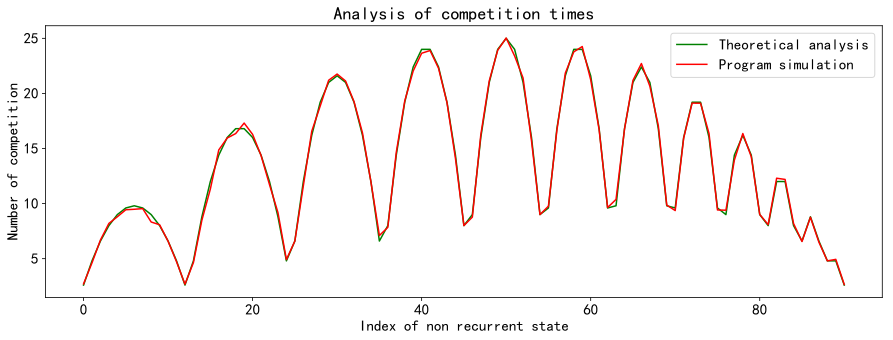

In [14]:
plt.figure(figsize=(15,5), dpi = 144)
plt.title('Analysis of competition times')
plt.plot(list(range(len(w))), w, color='green', label='Theoretical analysis')
plt.plot(list(range(len(w))), simulation_times, color='red', label='Program simulation')
plt.legend() # Show legend
plt.xlabel('Index of non recurrent state')
plt.ylabel('Number of competition')
plt.savefig('figure/Task2-Analysis of competition times.png')
plt.show() 

上图中横坐标是所有的初始的非常返态，纵坐标是从对应的非常返态到吸收态（从游戏开始到游戏结束）所对弈的平均次数。

理论计算和实际仿真出来得平均绝对误差为0.21，可以认为理论计算和实际仿真得结果基本一致。

### c. 游戏结束时赌博的平均次数与初始硬币数分布关系

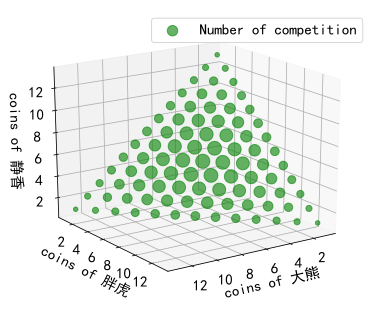

In [15]:
# Scatter plot
fig = plt.figure(figsize=(5,4), dpi=144)
ax = Axes3D(fig)
elev = 20.0
azim = 55.5
ax.view_init(elev, azim)
ax.scatter(np.array(non_recurrent_states)[:,0], np.array(non_recurrent_states)[:,1], np.array(non_recurrent_states)[:,2], s=w[:]*8, c='g', marker='o', label='Number of competition', alpha=0.6)
ax.set_xlabel('coins of 大熊')
ax.set_ylabel('coins of 胖虎')
ax.set_zlabel('coins of 静香')
plt.legend()
plt.show()

上图中，不同得绿色圆圈代表了不同得起始状态（初始得三个玩家得硬币分布）博弈至游戏结束所需要得平均博弈次数，绿色圆圈越大表示平均博弈次数也越大。

从中可以发现，当三名玩家得硬币分布接近一致时，所需要得博弈次数也越多，这和我们的认知常识是一致得。

# Section III. 计算从非常返态到吸收态的转移概率

### i. 构造R矩阵

非常返态到吸收态的转移概率计算：
1. 三名玩家中，有个玩家的硬币数降低1，另一个玩家的硬币数增加1。
2. 硬币数变为0的玩家，前一状态的生命值为1。

符合上述条件的非常返态和吸收态之间的转移概率为1/6。 

In [16]:
R = np.zeros((p,q))
for idx1, state_a in enumerate(non_recurrent_states):
    for idx2, state_b in enumerate(absorbing_states):
        neighbor_res = judge_neighbor_state(state_a, state_b)
        if neighbor_res == 1:
            R[idx1][idx2] = 1/6

In [17]:
save_matrix(R, 'log/Task2-information_of_R_matrix.csv')

### ii. 理论计算游戏结束时硬币数的分布

In [18]:
I = np.eye(p)
U = np.dot(np.linalg.inv(I - D), R)
U.shape

(91, 42)

In [19]:
save_matrix(U, 'log/Task2-information_of_U_matrix.csv')

### iii. 仿真模拟游戏结束时硬币数的分布

In [20]:
simulation_probabilitys = []
total_res = []
# For every initial state(distribution of coins at start of game)
for idx, state in enumerate(non_recurrent_states):
    res = simulation(state[0], state[1], state[2], total_simulation)
    total_res.append(res)
    res_absorbing_state_index = [absorbing_states.index(tuple(ele[:3])) for ele in res]
    hist, bin_edges = np.histogram(res_absorbing_state_index, bins=list(range(0,len(absorbing_states)+1)), density=True)
    simulation_probabilitys.append(hist)
simulation_probabilitys = np.array(simulation_probabilitys)
np.save('log/task2_simulation_probabilitys.npy', simulation_probabilitys)

In [21]:
simulation_probabilitys[:2]

array([[0.17733333, 0.23133333, 0.05266667, 0.01966667, 0.00766667,
        0.005     , 0.00166667, 0.00166667, 0.        , 0.        ,
        0.00033333, 0.00033333, 0.        , 0.        , 0.18233333,
        0.221     , 0.06233333, 0.01733333, 0.00633333, 0.00366667,
        0.003     , 0.001     , 0.00066667, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00033333, 0.00033333,
        0.        , 0.00033333, 0.00033333, 0.00066667, 0.00066667,
        0.00066667, 0.        , 0.00033333, 0.001     , 0.        ,
        0.        , 0.        ],
       [0.05266667, 0.244     , 0.25833333, 0.075     , 0.02833333,
        0.015     , 0.00633333, 0.00266667, 0.001     , 0.00133333,
        0.00066667, 0.00033333, 0.        , 0.        , 0.04166667,
        0.08766667, 0.08733333, 0.04333333, 0.021     , 0.00933333,
        0.00566667, 0.00533333, 0.004     , 0.00066667, 0.00133333,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.     

### iv. 数据分析

#### a. 理论计算与仿真模拟的平均绝对误差

In [22]:
# calculate the mean of absolute error
np.mean(np.abs(U-simulation_probabilitys))

0.001663037579449491

#### b. 理论计算与仿真模拟对比

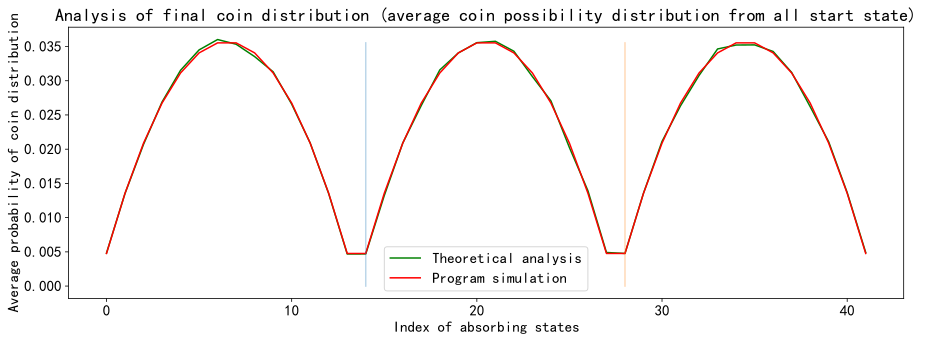

In [23]:
plt.figure(figsize=(15,5), dpi = 144)
plt.title('Analysis of final coin distribution (average coin possibility distribution from all start state)')
plt.plot(list(range(q)), np.mean(simulation_probabilitys, axis=0), color='green', label='Theoretical analysis')
plt.plot(list(range(q)), np.mean(U, axis=0), color='red', label='Program simulation')

points = [ (q/3,np.max(np.mean(U, axis=0))), (q*2/3,np.max(np.mean(U, axis=0))) ] # (a1,b1), (a2,b2), ...
for pt in points:
    plt.plot( [pt[0],pt[0]], [0,pt[1]], alpha=0.3)
    
plt.legend()
plt.xlabel('Index of absorbing states')
plt.ylabel('Average probability of coin distribution')
plt.savefig('figure/Task2-Analysis of average coin distribution.png')
plt.show() 

上图中横坐标是所有的吸收态，纵坐标是从对应的从所有非常返态到该吸收态的平均概率。

理论计算和实际仿真出来得平均绝对误差为0.0016，可以认为理论计算和实际仿真得结果基本一致。

#### c. 从初始硬币数为(5,5,5)到游戏结束时每种硬币数分布的概率

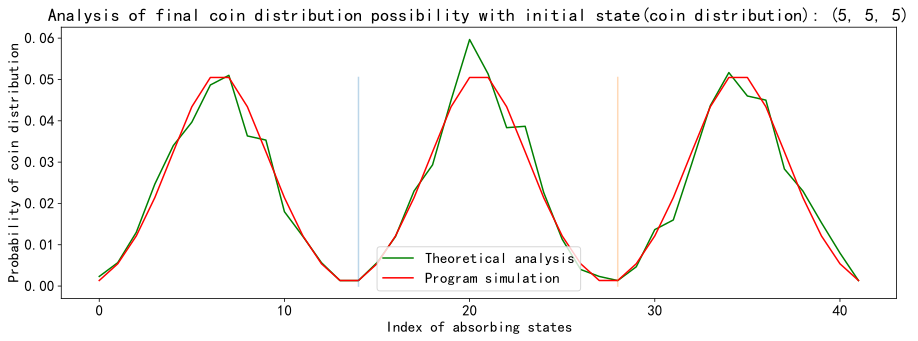

In [24]:
# The initial state is when all three have 5 coins
index = non_recurrent_states.index((money_a, money_b, money_c))

plt.figure(figsize=(15,5), dpi = 144)
plt.title('Analysis of final coin distribution possibility with initial state(coin distribution): %s'%str(non_recurrent_states[index]))
plt.plot(list(range(q)), simulation_probabilitys[index], color='green', label='Theoretical analysis')
plt.plot(list(range(q)), U[index], color='red', label='Program simulation')

points = [(q/3,np.max(U[index])), (q*2/3,np.max(U[index])) ] # (a1,b1), (a2,b2), ...
for pt in points:
    plt.plot( [pt[0],pt[0]], [0,pt[1]], alpha=0.3)

plt.legend() # 显示图例
plt.xlabel('Index of absorbing states')
plt.ylabel('Probability of coin distribution')
plt.savefig('figure/Task2-Analysis of coin distribution.png')
plt.show() 

#### d. 从初始硬币数为(5,5,5)到游戏结束时每种硬币数分布

Suppose the names of three players are "大熊", "胖虎" and "静香"


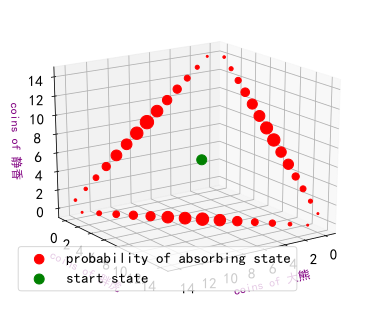

In [25]:
player = {'a':money_a, 'b':money_b, 'c':money_c}
print('Suppose the names of three players are "大熊", "胖虎" and "静香"')
player_name = list(["大熊", "胖虎" , "静香"])

index = non_recurrent_states.index((money_a, money_b, money_c))
results = total_res[index]

# Scatter plot
fig = plt.figure(figsize=(5,4), dpi=144)
ax = Axes3D(fig)
elev = 20.0
azim = 55.5
ax.view_init(elev, azim)

simulate_hit_counts = []
for idx, state in enumerate(absorbing_states):
    simulate_hit_count = np.where(np.sum(results[:,:3]==state, axis=1) == 3)[0].shape[0]
    simulate_hit_counts.append(simulate_hit_count)

ax.scatter(np.array(absorbing_states)[:,0], np.array(absorbing_states)[:,1], np.array(absorbing_states)[:,2], c = 'r', s = simulate_hit_counts, alpha = 1, label = 'probability of absorbing state')
ax.scatter(non_recurrent_states[index][0], non_recurrent_states[index][1], non_recurrent_states[index][2], c = 'g', s = 100, alpha = 1, label = 'start state')
# Add the axes (the order is Z, Y, X)
ax.set_xlabel('coins of 大熊', fontdict={'size': 12, 'color': 'purple'})
ax.set_ylabel('coins of 胖虎', fontdict={'size': 12, 'color': 'purple'})
ax.set_zlabel('coins of 静香', fontdict={'size': 12, 'color': 'purple'})
plt.legend()
plt.show()

上图中，绿色的圆圈表示初始状态（初始得三个玩家的硬币数为(5,5,5)）的位置。

不同的红色圆圈代表了从起始状态博弈至游戏结束的硬币分布概率，红色圆圈越大表示最终为该硬币分布的概率越大。

从中可以发现，当三名玩家得硬币分布接近一致时，最终的硬币分布也是对称的，且另外两个仍有硬币的玩家的硬币数也是大概率是一样的，和我们的认知常识保持一致。

#### e. 任选几个初始硬币数分布到游戏结束时的硬币数概率分布

Suppose the names of three players are "大熊", "胖虎" and "静香"


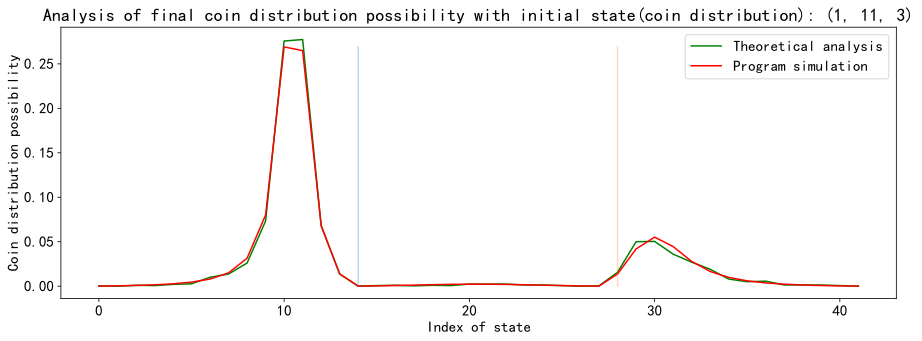

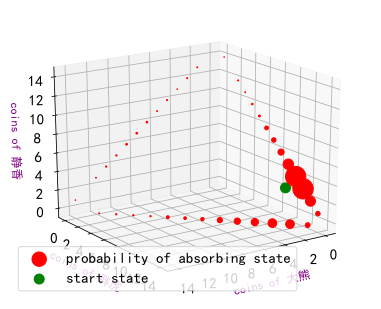

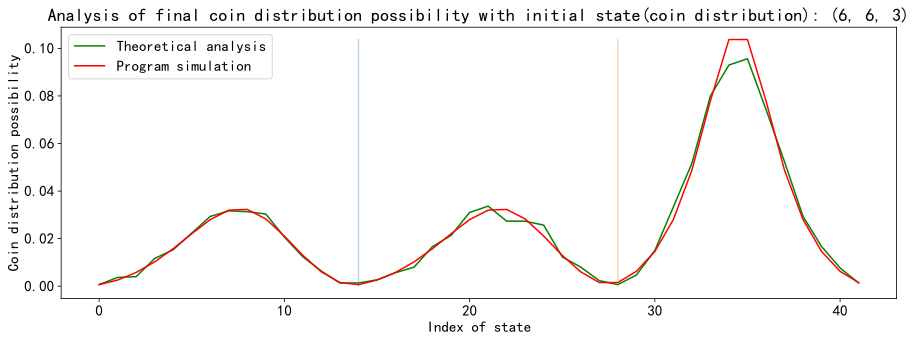

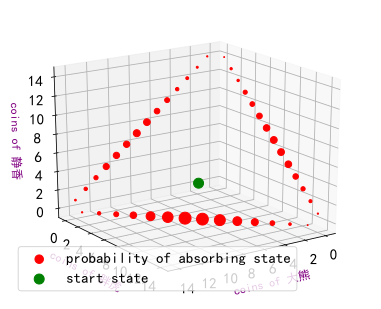

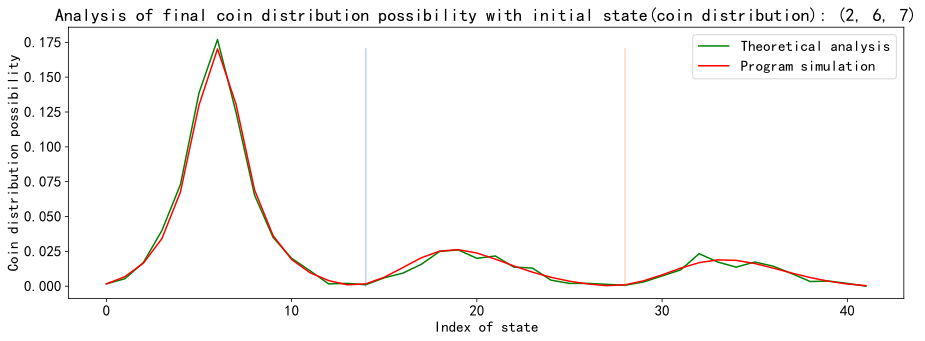

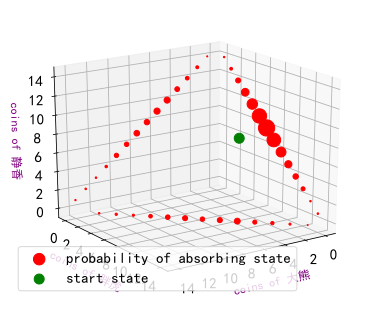

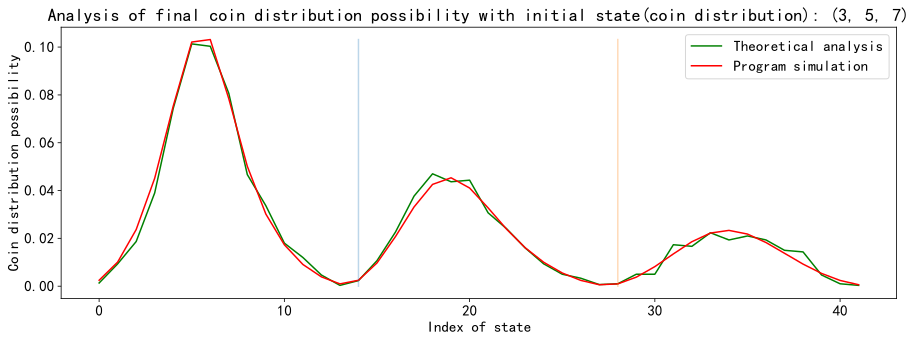

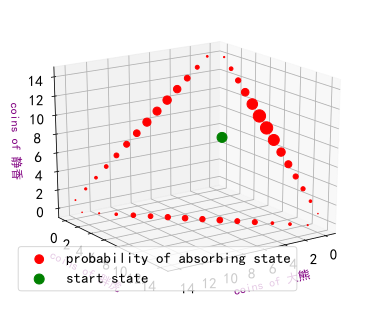

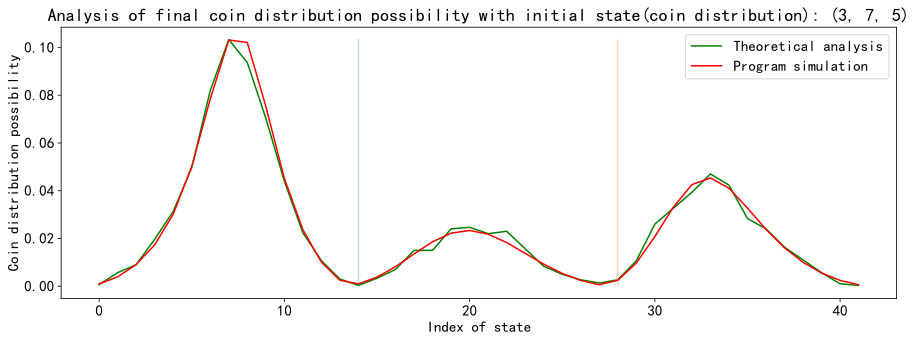

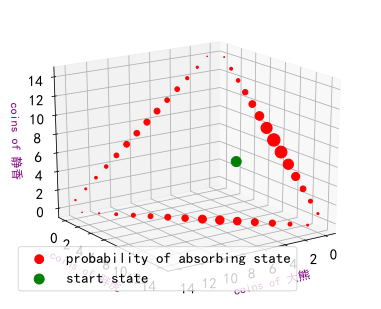

In [26]:
player = {'a':money_a, 'b':money_b, 'c':money_c}
print('Suppose the names of three players are "大熊", "胖虎" and "静香"')
player_name = list(["大熊", "胖虎" , "静香"])

# Randomly select several initial states and observe the final distribution
random_selected_index = np.random.randint(p, size=5)
for index in random_selected_index:
    '''2D view'''
    plt.figure(figsize=(15,5), dpi = 144)
    plt.title('Analysis of final coin distribution possibility with initial state(coin distribution): %s'%str(non_recurrent_states[index]))
    plt.plot(list(range(q)), simulation_probabilitys[index], color='green', label='Theoretical analysis')
    plt.plot(list(range(q)), U[index], color='red', label='Program simulation')

    points = [ (q/3,np.max(U[index])), (q*2/3,np.max(U[index])) ] # (a1,b1), (a2,b2), ...
    for pt in points:
        plt.plot( [pt[0],pt[0]], [0,pt[1]], alpha=0.3)

    plt.legend() # 显示图例
    plt.xlabel('Index of state')
    plt.ylabel('Coin distribution possibility')
    plt.show() 
    
    '''3D view'''
    results = total_res[index]
    # Scatter plot
    fig = plt.figure(figsize=(5,4), dpi=144)
    ax = Axes3D(fig)
    elev = 20.0
    azim = 55.5
    ax.view_init(elev, azim)
    simulate_hit_counts = []
    for idx, state in enumerate(absorbing_states):
        simulate_hit_count = np.where(np.sum(results[:,:3]==state, axis=1) == 3)[0].shape[0]
        simulate_hit_counts.append(simulate_hit_count/2)
    ax.scatter(np.array(absorbing_states)[:,0], np.array(absorbing_states)[:,1], np.array(absorbing_states)[:,2], c = 'r', s = simulate_hit_counts, alpha = 1, label = 'probability of absorbing state')
    ax.scatter(non_recurrent_states[index][0], non_recurrent_states[index][1], non_recurrent_states[index][2], c = 'g', s = 100, alpha = 1, label = 'start state')
    # Add the axes (the order is X, Y, Z)
    ax.set_xlabel('coins of 大熊', fontdict={'size': 12, 'color': 'purple'})
    ax.set_ylabel('coins of 胖虎', fontdict={'size': 12, 'color': 'purple'})
    ax.set_zlabel('coins of 静香', fontdict={'size': 12, 'color': 'purple'})
    plt.legend()
    plt.show()

显然，初始硬币数越少的玩家越有可能会输，所以最终硬币数的分布会拥有初始状态分布的趋势。

从上图中很明显可以看出，初始状态对吸收状态的分布影响很大。

#### f. 计算游戏结束时三个玩家的硬币数期望

In [27]:
'''Theoretical analysis'''
mean_coin_distribution = np.dot(U, np.array(absorbing_states))
mean_coin_distribution[:5]

array([[ 1.,  1., 13.],
       [ 1.,  2., 12.],
       [ 1.,  3., 11.],
       [ 1.,  4., 10.],
       [ 1.,  5.,  9.]])

In [28]:
'''Program simulation'''
simulation_coin_distribution = []
# for every initial state(distribution of coins at the start of game)
for idx, state in enumerate(non_recurrent_states):
    res = simulation(state[0], state[1], state[2], total_simulation)    
    simulation_coin_distribution.append(np.mean(res[:,:3], axis=0)) 
simulation_coin_distribution = np.array(simulation_coin_distribution)

In [29]:
simulation_coin_distribution[:5]

array([[ 0.97933333,  1.01      , 13.01066667],
       [ 0.97466667,  1.97933333, 12.046     ],
       [ 0.95033333,  3.055     , 10.99466667],
       [ 1.01733333,  3.95466667, 10.028     ],
       [ 0.963     ,  5.02433333,  9.01266667]])

In [30]:
'''MAE'''
np.mean(np.abs(mean_coin_distribution - simulation_coin_distribution))

0.038227106227106386

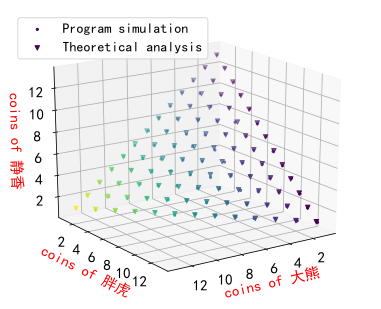

In [31]:
'''Plot the scatter'''
# Scatter plot
fig = plt.figure(figsize=(5,4), dpi=144)
ax = Axes3D(fig)
# Change view
elev = 20.0
azim = 55.5
ax.view_init(elev, azim)
# Draw theoretical and practical scatter plots
ax.scatter(simulation_coin_distribution[:,0], simulation_coin_distribution[:,1], simulation_coin_distribution[:,2], c = simulation_coin_distribution[:,0], cmap='viridis', marker='.', label='Program simulation')
ax.scatter(mean_coin_distribution[:,0], mean_coin_distribution[:,1], mean_coin_distribution[:,2], c = mean_coin_distribution[:,0], cmap='viridis', marker='v', label='Theoretical analysis')
# Add the axes (the order is X, Y, Z)
ax.set_xlabel('coins of 大熊', fontdict={'size': 15, 'color': 'red'})
ax.set_ylabel('coins of 胖虎', fontdict={'size': 15, 'color': 'red'})
ax.set_zlabel('coins of 静香', fontdict={'size': 15, 'color': 'red'})
plt.legend(fontsize=14)
plt.show()

在对游戏结束时三个玩家的硬币数期望计算中，理论计算和实际仿真出来得平均绝对误差为0.0438，可以认为理论计算和实际仿真得结果基本一致。

上图中表示从任一的初始硬币数分布开始博弈，游戏结束时，三人手中的硬币数分布期望和初始硬币数分布一致。

这个结果也是和常识一致的。在公平的条件，除去技艺的高低，每个人每局胜负的可能性都是一致的，所以近似盈亏相等，只不过因为开局拥有的钱少所以就先出局。

#### g. 在某个指定玩家首先出局的情况下，计算其他两名玩家的硬币期望数

In [32]:
'''Theoretical analysis'''
condition_absorbing_state_coins = []
temp_absorbing_states = np.array(absorbing_states)
for idx, state in enumerate(non_recurrent_states):
    absorbing_state_coin = []
    for i in [0,1,2]: # 根据一开始计算的吸收态来的 
        part_absorbing_state_index = np.where(temp_absorbing_states[:,i] == 0)
        part_absorbing_state = temp_absorbing_states[part_absorbing_state_index]
        part_absorbing_state_possibility = U[idx, part_absorbing_state_index][0]
        part_absorbing_state_possibility /= np.sum(part_absorbing_state_possibility)
        part_absorbing_state_coin = np.sum(np.dot(np.diag(part_absorbing_state_possibility), part_absorbing_state), axis = 0)
        absorbing_state_coin.append(list(part_absorbing_state_coin))
    condition_absorbing_state_coins.append(absorbing_state_coin)
condition_absorbing_state_coins = np.array(condition_absorbing_state_coins)

In [33]:
condition_absorbing_state_coins[:5]

array([[[ 0.        ,  1.96477503, 13.03522497],
        [ 1.96477503,  0.        , 13.03522497],
        [ 7.5       ,  7.5       ,  0.        ]],

       [[ 0.        ,  2.86365776, 12.13634224],
        [ 2.98422957,  0.        , 12.01577043],
        [ 7.47547798,  7.52452202,  0.        ]],

       [[ 0.        ,  3.78548032, 11.21451968],
        [ 3.93149946,  0.        , 11.06850054],
        [ 7.41417983,  7.58582017,  0.        ]],

       [[ 0.        ,  4.71340533, 10.28659467],
        [ 4.76369923,  0.        , 10.23630077],
        [ 7.30142335,  7.69857665,  0.        ]],

       [[ 0.        ,  5.64245027,  9.35754973],
        [ 5.46904712,  0.        ,  9.53095288],
        [ 7.12260171,  7.87739829,  0.        ]]])

In [34]:
'''Program simulation'''
condition_simulation_coin_distribution = []
# For every initial state(distribution of coins at the start of game)
for idx, state in enumerate(non_recurrent_states):
    res = simulation(state[0], state[1], state[2], total_simulation)      
    condition_simulation_coin_distribution.append([np.mean(res[np.where(res[:,0] == 0)][:,:3], axis=0), np.mean(res[np.where(res[:,1] == 0)][:,:3], axis=0), np.mean(res[np.where(res[:,2] == 0)][:,:3], axis=0)]) 
condition_simulation_coin_distribution = np.array(condition_simulation_coin_distribution)

In [35]:
condition_simulation_coin_distribution[:5]

array([[[ 0.        ,  1.97415507, 13.02584493],
        [ 1.96698113,  0.        , 13.03301887],
        [ 7.71428571,  7.28571429,  0.        ]],

       [[ 0.        ,  2.88501742, 12.11498258],
        [ 2.95534787,  0.        , 12.04465213],
        [ 7.42857143,  7.57142857,  0.        ]],

       [[ 0.        ,  3.76611498, 11.23388502],
        [ 3.79487179,  0.        , 11.20512821],
        [ 7.80487805,  7.19512195,  0.        ]],

       [[ 0.        ,  4.7088713 , 10.2911287 ],
        [ 4.7797619 ,  0.        , 10.2202381 ],
        [ 7.30526316,  7.69473684,  0.        ]],

       [[ 0.        ,  5.64973588,  9.35026412],
        [ 5.58072289,  0.        ,  9.41927711],
        [ 6.66129032,  8.33870968,  0.        ]]])

In [36]:
'''MAE'''
np.mean(np.abs(condition_absorbing_state_coins - condition_simulation_coin_distribution))

0.06156375795805822

理论计算与模拟仿真的误差后发现，两者几乎一致

In [37]:
'''Find regular pattern'''
a_start = np.array(non_recurrent_states)[:,0]
b_start = np.array(non_recurrent_states)[:,1]
c_start = np.array(non_recurrent_states)[:,2]
b = b_start+a_start*c_start/(b_start+c_start)
c = a_start+c_start-a_start*c_start/(b_start+c_start)

In [38]:
np.mean(np.abs(b - condition_simulation_coin_distribution[:, 0, 1])) #大熊没钱时胖虎的硬币分布

0.3052123002862957

In [39]:
np.mean(np.abs(c - condition_simulation_coin_distribution[:, 0, 2])) #大熊没钱时静香的硬币分布

0.3052123002862957

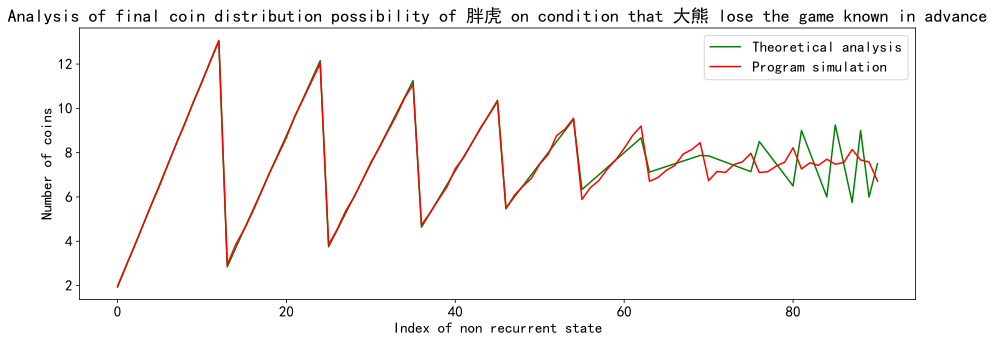

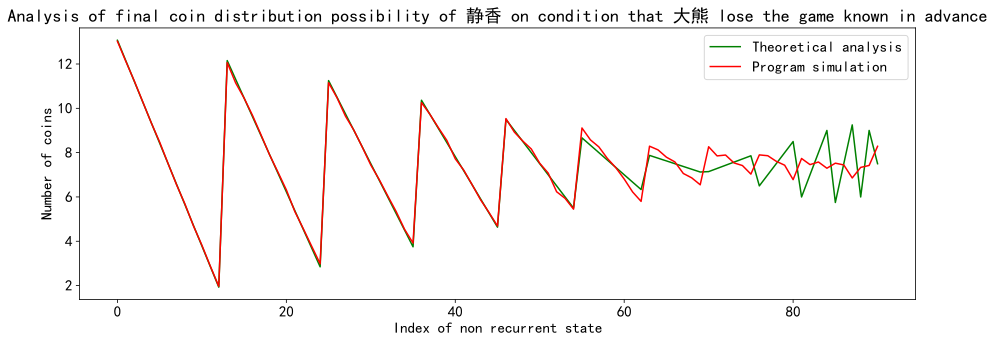

In [40]:
'''2D view'''
plt.figure(figsize=(15,5), dpi = 144)
plt.title('Analysis of final coin distribution possibility of 胖虎 on condition that 大熊 lose the game known in advance')
plt.plot(list(range(p)), b, color='green', label='Theoretical analysis')
plt.plot(list(range(p)), condition_simulation_coin_distribution[:, 0, 1], color='red', label='Program simulation')
plt.legend() 
plt.xlabel('Index of non recurrent state')
plt.ylabel('Number of coins')
plt.show() 

plt.figure(figsize=(15,5), dpi = 144)
plt.title('Analysis of final coin distribution possibility of 静香 on condition that 大熊 lose the game known in advance')
plt.plot(list(range(p)), c, color='green', label='Theoretical analysis')
plt.plot(list(range(p)), condition_simulation_coin_distribution[:, 0, 2], color='red', label='Program simulation')
plt.legend()
plt.xlabel('Index of non recurrent state')
plt.ylabel('Number of coins')
plt.show() 

令(a,b,c)分别为三名玩家初始硬币数，(x,y,z)为三名玩家游戏结束时硬币数。

则游戏结束时某名指定玩家没有硬币时其他两位玩家硬币分布的计算公式服从规律：

$$x=0$$ 则：

$$y=b+a * \frac c{b+c}$$


$$z=a+c-a * \frac c{b+c}$$

根据对称性，易知y=0时以及z=0时其他两名玩家的硬币分布数。